In [1]:
# Point to the folder that contains dataset_dict.json (NOT directly to train/)
VQARAD_PATH = "/content/drive/MyDrive/data/VQA_RAD"

# Do the same for SLAKE when you place it (adjust this to your actual path):
SLAKE_PATH  = "/content/drive/MyDrive/data/SLAKE"

OUT_DIR = "/content/drive/MyDrive/data/outputs_cfproxy"
!mkdir -p "$OUT_DIR"

In [3]:
from datasets import load_from_disk

vqa_rad = load_from_disk(VQARAD_PATH)  # returns a DatasetDict because dataset_dict.json exists
print(vqa_rad)                         # Expect: DatasetDict with 'train' and 'test'

# Pick a split
vqa_rad_train = vqa_rad["train"]
vqa_rad_test  = vqa_rad["test"]

# Quick sanity check
row = vqa_rad_test[0]
print(row.keys())       # -> dict_keys(['image','question','answer', ...])
print(row["question"], "->", row["answer"])
row["image"].show()

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})
dict_keys(['image', 'question', 'answer'])
is there evidence of an aortic aneurysm? -> yes


In [ ]:
!pip -q install "transformers>=4.44" accelerate torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install datasets pillow opencv-python rapidfuzz tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.9 MB/s eta 0:00:00


In [ ]:
VQARAD_PATH = "/content/drive/MyDrive/data/VQA_RAD"
OUT_DIR = "/content/drive/MyDrive/data/outputs_cfproxy"

from pathlib import Path
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

from datasets import load_from_disk
vqa = load_from_disk(VQARAD_PATH)
ds_train, ds_test = vqa["train"], vqa["test"]

def iter_samples(ds, n=None):
    m = len(ds) if n is None else min(n, len(ds))
    for i in range(m):
        r = ds[i]
        yield i, r["image"], r["question"], r["answer"]

In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model = AutoModelForVision2Seq.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32,
    trust_remote_code=True
).eval()

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

In [ ]:
def prompt_think_answer(q):
    return f'''You are a medical VQA assistant. Think carefully but return ONLY valid JSON:
{{"answer":"<short answer>"}}

Rules:
- Do not use code fences or backticks.
- No extra keys or text beyond the JSON.
- If your output is not valid JSON, immediately try again and output ONLY valid JSON.
Question: "{q}"'''

def prompt_caption_reason_answer(q):
    return f'''You are a medical VQA assistant. First DESCRIBE the image, then REASON, then ANSWER.
Return ONLY valid JSON with exactly these keys:
{{
 "caption":"<1-2 precise sentences about visible anatomy/findings>",
 "reasoning":["<step1>","<step2>","<step3>"],
 "boxes":[[x1,y1,x2,y2]],
 "answer":"<short answer>"
}}
Rules:
- Do not use code fences or backticks.
- No extra keys or text beyond the JSON.
- Use integers for box coordinates within image bounds.
- If your output is not valid JSON, immediately try again and output ONLY valid JSON.
- Output at most 1 box tightly enclosing the most diagnostic finding (avoid full-organ boxes).
- The box must be as small as possible while still covering the key evidence.

Question: "{q}"'''

In [ ]:
import json, re

def parse_json_safe(text):
    m = re.search(r"\{.*\}", text, re.DOTALL)
    if not m:
        return None
    chunk = m.group(0)
    # minimal repairs: strip trailing commas before } or ]
    chunk = re.sub(r",(\s*[}\]])", r"\1", chunk)
    try:
        return json.loads(chunk)
    except:
        return None


@torch.inference_mode()
def call_vlm(image_pil, prompt, max_new_tokens=384, temperature=0.2, top_p=0.9):
    # Messages with system role + image attached to the user turn
    messages = [
        {"role": "system", "content": "You are a helpful medical VQA assistant."},
        {"role": "user", "content": [
            {"type": "image"},                      # placeholder token in chat text
            {"type": "text", "text": prompt}
        ]}
    ]

    # 1) Get chat string (not tensors)
    chat_str = processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # 2) Build tensors from (chat string + image)
    inputs = processor(
        text=[chat_str],
        images=[image_pil],
        return_tensors="pt"
    ).to(DEVICE)

    input_len = inputs["input_ids"].shape[-1]  # number of tokens in the prompt

    # 3) Generate
    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=(temperature > 0),
        temperature=temperature,
        top_p=top_p,
        pad_token_id=processor.tokenizer.eos_token_id,
        eos_token_id=processor.tokenizer.eos_token_id
    )

    # 4) Decode only the NEW tokens
    new_tokens = output_ids[0, input_len:]
    out = processor.tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    return out  # parse_json_safe(out) should now find the JSON

In [ ]:
i, img, q, gold = next(iter(iter_samples(ds_test, n=1)))
print("Q:", q, "| gold:", gold)

raw = call_vlm(img, prompt_caption_reason_answer(q))
print(raw[:500])            # should now show JSON or at least model text, not the system/user prelude
print(parse_json_safe(raw)) # should be a dict (or None if malformed)

Q: is there evidence of an aortic aneurysm? | gold: yes
```json
{
  "caption": "The image shows a chest X-ray with a pacemaker and no evidence of an aortic aneurysm.",
  "reasoning": [
    "The pacemaker is located in the chest cavity, not in the aorta.",
    "There are no visible signs of an aortic aneurysm such as bulging or enlargement of the aorta."
  ],
  "boxes": [
    [100, 100, 850, 900]
  ],
  "answer": "No, there is no evidence of an aortic aneurysm."
}
```
{'caption': 'The image shows a chest X-ray with a pacemaker and no evidence of an aortic aneurysm.', 'reasoning': ['The pacemaker is located in the chest cavity, not in the aorta.', 'There are no visible signs of an aortic aneurysm such as bulging or enlargement of the aorta.'], 'boxes': [[100, 100, 850, 900]], 'answer': 'No, there is no evidence of an aortic aneurysm.'}


In [ ]:
# run_protocol(ds_test, f"{OUT_DIR}/vqarad_think_20.jsonl", prompt_think_answer, limit=20)
# run_protocol(ds_test, f"{OUT_DIR}/vqarad_cap_20.jsonl",   prompt_caption_reason_answer, limit=20)

100%|██████████| 20/20 [03:08<00:00,  9.45s/it]


In [ ]:
# Inference for 200
run_protocol(ds_test, f"{OUT_DIR}/vqarad_think.jsonl", prompt_think_answer, limit=200)
run_protocol(ds_test, f"{OUT_DIR}/vqarad_cap.jsonl",   prompt_caption_reason_answer, limit=200)

100%|██████████| 200/200 [27:09<00:00,  8.15s/it]


In [ ]:
import json, re
from rapidfuzz.fuzz import partial_ratio

# ---------- helpers ----------
def has_json(r):
    return isinstance(r, dict) and isinstance(r.get("json"), dict)

def has_boxes(r):
    if not has_json(r):
        return False
    b = r["json"].get("boxes", None)
    return isinstance(b, list) and len(b) > 0

def normalize_answer(a: str) -> str:
    if not a: return ""
    a = a.strip().lower()
    if a.startswith("y"): return "yes"
    if a.startswith("n"): return "no"
    return re.sub(r"[^a-z0-9 .-]", "", a)

def accuracy(records):
    ok=n=0
    for r in records:
        if not has_json(r):
            continue
        pred = normalize_answer(r["json"].get("answer",""))
        gold = normalize_answer(r.get("gold",""))
        if pred and gold:
            ok += int(pred==gold); n += 1
    return ok/max(1,n)

# caption–question consistency (for risk–coverage)
ORGANS={"lung","heart","liver","kidney","skull","brain","spine","rib","femur","arm","chest"}
SIDES ={"left","right","bilateral","unilateral"}
FINDINGS={"mass","nodule","lesion","fracture","opacity","effusion","consolidation","atelectasis","pneumothorax"}

def norm(s):
    return re.sub(r"[^a-z0-9 ]","", s.lower()) if s else ""

def consistency_score(q, cap):
    if not cap: return 0.0
    qn, cn = norm(q), norm(cap)
    q_terms = [t for t in ORGANS|SIDES|FINDINGS if t in qn]
    term_cov = sum(1 for t in q_terms if t in cn)/max(1,len(q_terms))
    sem = partial_ratio(qn, cn)/100.0
    return 0.7*term_cov + 0.3*sem

def risk_coverage(records, tau):
    kept=[]
    for r in records:
        if not has_json(r):
            continue
        cap = r["json"].get("caption","")
        score = consistency_score(r["question"], cap)
        if score >= tau:
            kept.append(r)
    cov = len(kept)/max(1,len(records))
    acc = accuracy(kept) if kept else 0.0
    return cov, acc, 1.0-acc

In [ ]:
think200 = [json.loads(x) for x in open(f"{OUT_DIR}/vqarad_think.jsonl",'r',encoding='utf-8')]
cap200   = [json.loads(x) for x in open(f"{OUT_DIR}/vqarad_cap.jsonl",'r',encoding='utf-8')]

print("Parsed:", sum(has_json(r) for r in cap200), "/", len(cap200))
print("Has boxes:", sum(has_boxes(r) for r in cap200), "/", len(cap200))
print("Acc Think→Answer (200):", accuracy(think200))
print("Acc Caption→Reason→Answer (200):", accuracy(cap200))

for t in [0.3,0.4,0.5,0.6]:
    cov, acc, risk = risk_coverage(cap200, t)
    print(f"Risk–Coverage τ={t:.1f}: coverage={cov:.2f}, acc={acc:.2f}, risk={risk:.2f}")

Parsed: 183 / 200
Has boxes: 151 / 200
Acc Think→Answer (200): 0.385
Acc Caption→Reason→Answer (200): 0.35911602209944754
Risk–Coverage τ=0.3: coverage=0.39, acc=0.29, risk=0.71
Risk–Coverage τ=0.4: coverage=0.39, acc=0.29, risk=0.71
Risk–Coverage τ=0.5: coverage=0.39, acc=0.29, risk=0.71
Risk–Coverage τ=0.6: coverage=0.36, acc=0.27, risk=0.73


In [ ]:
# --- Counterfactuals on 200 (ROI-CF with shrink + inpaint) ---

import json, re, random
import numpy as np, cv2
from PIL import Image

random.seed(0); np.random.seed(0)

# assumes: normalize_answer, parse_json_safe, call_vlm, prompt_caption_reason_answer already defined

def answer_from_json(js):
    return normalize_answer((js or {}).get("answer",""))

def boxes_from_json(js):
    bx = (js or {}).get("boxes", [])
    return bx if isinstance(bx, list) else []

def box_area_frac(boxes, w, h):
    if not boxes: return 0.0
    x1,y1,x2,y2 = [int(v) for v in boxes[0]]
    x1 = max(0,min(w-1,x1)); x2 = max(0,min(w-1,x2))
    y1 = max(0,min(h-1,y1)); y2 = max(0,min(h-1,y2))
    A = max(0, x2-x1) * max(0, y2-y1)
    return A / max(1, w*h)

def shrink_box(b, w, h, frac=0.2):
    x1,y1,x2,y2 = [int(v) for v in b]
    cx, cy = (x1+x2)//2, (y1+y2)//2
    bw, bh = max(1, x2-x1), max(1, y2-y1)
    nx = max(1, int(bw*(1-frac)))
    ny = max(1, int(bh*(1-frac)))
    x1n, x2n = cx - nx//2, cx + nx//2
    y1n, y2n = cy - ny//2, cy + ny//2
    x1n = max(0, min(w-1, x1n)); x2n = max(0, min(w-1, x2n))
    y1n = max(0, min(h-1, y1n)); y2n = max(0, min(h-1, y2n))
    if x2n <= x1n or y2n <= y1n:
        return [x1, y1, x2, y2]
    return [x1n, y1n, x2n, y2n]

def shrink_boxes(boxes, w, h, frac=0.2):
    return [shrink_box(boxes[0], w, h, frac)] if boxes else []

def inpaint_boxes(image_pil, boxes):
    img = np.array(image_pil.convert("RGB"))
    h, w = img.shape[:2]
    mask = np.zeros((h,w), np.uint8)
    for b in boxes:
        x1,y1,x2,y2 = [int(v) for v in b]
        x1 = max(0, min(w-1, x1)); x2 = max(0, min(w-1, x2))
        y1 = max(0, min(h-1, y1)); y2 = max(0, min(h-1, y2))
        if x2>x1 and y2>y1:
            mask[y1:y2, x1:x2] = 255
    if mask.max()==0:
        return image_pil
    out = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return Image.fromarray(out)

# load the 200-sample predictions and map dataset items
cap200   = [json.loads(x) for x in open(f"{OUT_DIR}/vqarad_cap.jsonl",'r',encoding='utf-8')]
items200 = {i: ds_test[i] for i in range(200)}

cf_records = []
with_box_total = 0

for r in cap200:
    js = r.get("json")
    if not isinstance(js, dict):
        continue
    boxes = boxes_from_json(js)
    if not boxes:
        continue
    with_box_total += 1

    item = items200.get(r["idx"])
    if item is None:
        continue

    img, q = item["image"], item["question"]
    w, h = img.size

    # skip non-diagnostic huge ROIs
    if box_area_frac(boxes, w, h) > 0.70:
        continue

    # shrink + inpaint (no extra blur)
    boxes_s = shrink_boxes(boxes, w, h, frac=0.2)  # try 0.3 if still coarse
    img_cf  = inpaint_boxes(img, boxes_s)

    raw_cf = call_vlm(img_cf, prompt_caption_reason_answer(q))
    js_cf  = parse_json_safe(raw_cf)
    ans0   = answer_from_json(js)
    ans_cf = answer_from_json(js_cf)
    faithful = (bool(ans0) and bool(ans_cf) and (ans_cf != ans0))

    r.update({"json_cf": js_cf, "answer_cf": ans_cf, "faithful": faithful})
    cf_records.append(r)

cf_cov   = len(cf_records) / max(1, with_box_total)
flip_roi = sum(1 for r in cf_records if r.get("faithful") is True) / max(1, len(cf_records))

print(f"CF coverage (200, box-cases): {cf_cov:.2f}")
print(f"ROI-CF flip rate (200): {flip_roi:.2f}")

CF coverage (200, box-cases): 0.94
ROI-CF flip rate (200): 0.39


In [ ]:
import numpy as np
np.random.seed(0)

def random_box_like(boxes, w, h):
    """Sample a random box with SAME size as the (possibly shrunk) first box."""
    if not boxes:
        return []
    x1,y1,x2,y2 = [int(v) for v in boxes[0]]
    bw, bh = max(1, x2-x1), max(1, y2-y1)
    rx1 = np.random.randint(0, max(1, w-bw))
    ry1 = np.random.randint(0, max(1, h-bh))
    return [[rx1, ry1, rx1+bw, ry1+bh]]

rand_flips, rand_total = 0, 0
for r in cap200:  # make sure cap200 is loaded
    js = r.get("json")
    if not isinstance(js, dict) or not boxes_from_json(js):
        continue

    item = items200.get(r["idx"])  # <-- use items200 for the first 200 items
    if item is None:
        continue

    img, q = item["image"], item["question"]
    w, h = img.size
    boxes = boxes_from_json(js)

    # same skip rule as ROI-CF
    if box_area_frac(boxes, w, h) > 0.70:
        continue

    # use SAME shrink as ROI-CF to define a fair size
    boxes_s = shrink_boxes(boxes, w, h, frac=0.2)
    rboxes  = random_box_like(boxes_s, w, h)

    # use inpainting (same intervention as ROI-CF)
    img_cf = inpaint_boxes(img, rboxes)
    raw_cf = call_vlm(img_cf, prompt_caption_reason_answer(q))
    js_cf  = parse_json_safe(raw_cf)

    ans0   = answer_from_json(js)
    ans_cf = answer_from_json(js_cf)

    if bool(ans0) and bool(ans_cf):
        rand_flips += int(ans_cf != ans0)
        rand_total += 1

rand_flip_rate = rand_flips / max(1, rand_total)
print("Random-CF flip rate (200):", f"{rand_flip_rate:.2f}")

Random-CF flip rate (200): 0.44


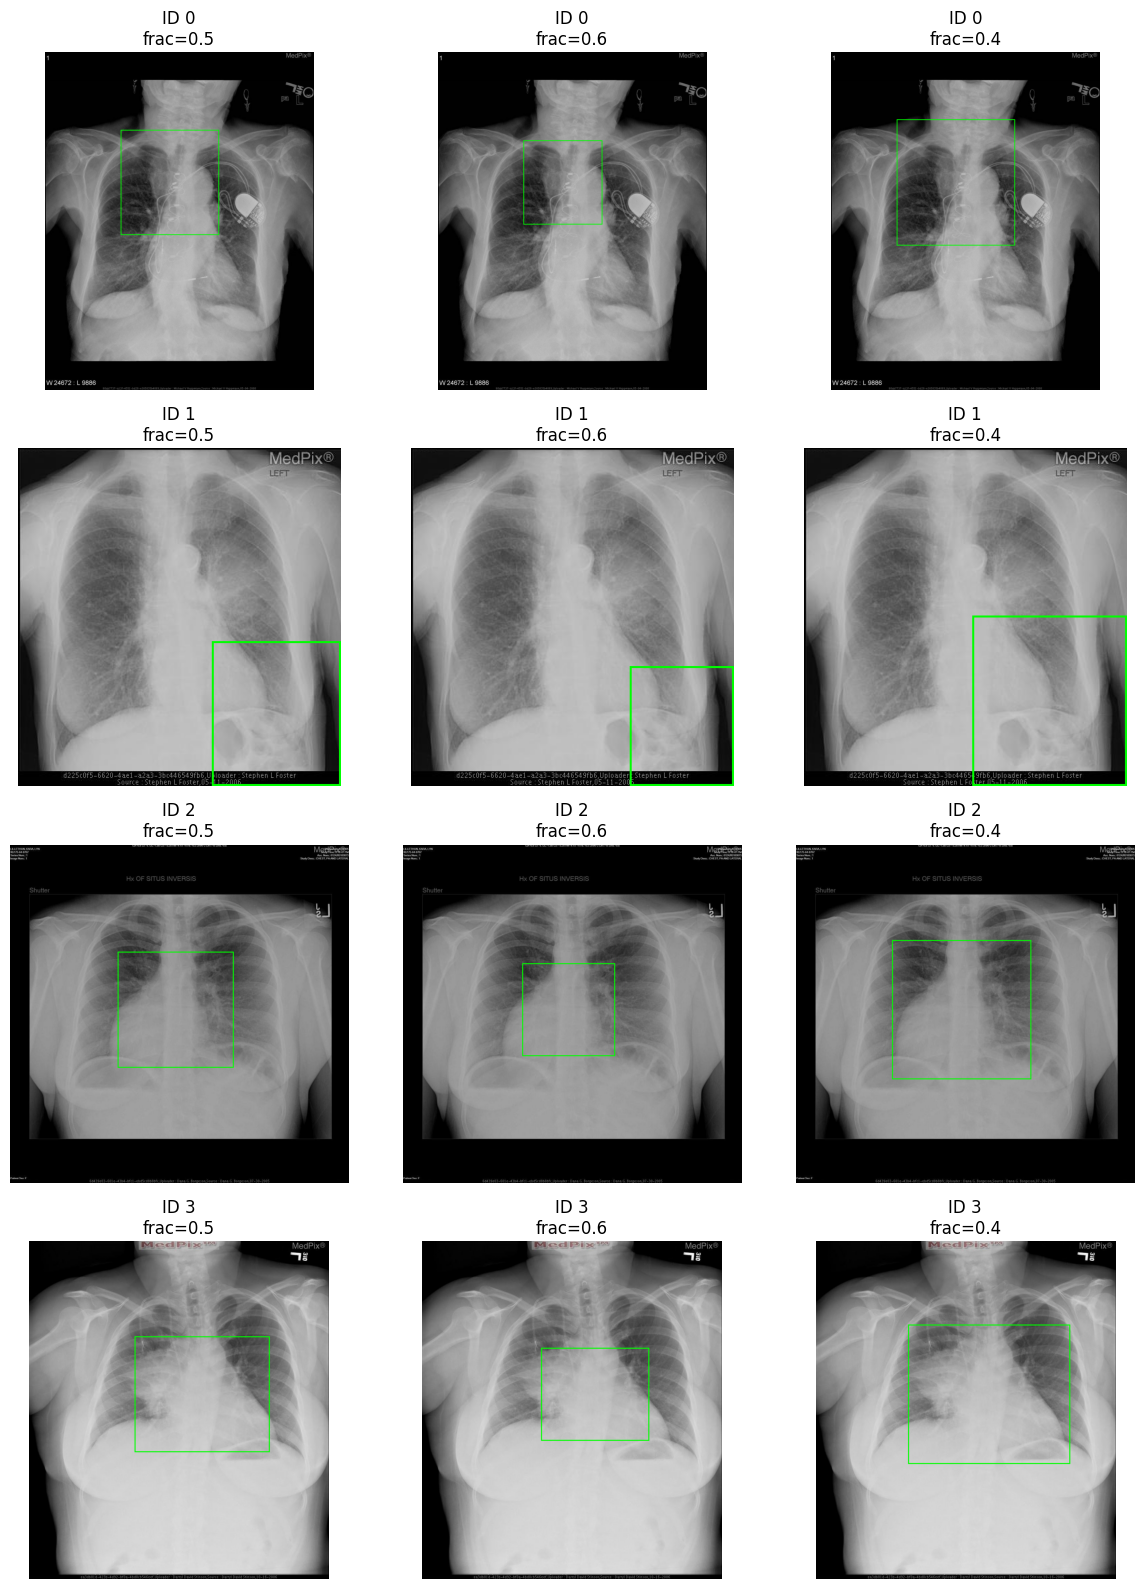

In [ ]:
import matplotlib.pyplot as plt
from PIL import ImageDraw

def draw_boxes(img, boxes, color=(0,255,0), width=3):
    img = img.convert("RGB")
    draw = ImageDraw.Draw(img)
    for b in boxes or []:
        x1,y1,x2,y2 = [int(v) for v in b]
        draw.rectangle([x1,y1,x2,y2], outline=color, width=width)
    return img

# pick 3–4 records with boxes
sample_ids = [i for i, r in enumerate(cap200) if has_boxes(r)][:4]
frac_values = frac_values = [0.5, 0.6, 0.4]  # shrink levels to compare

# create a grid: rows = samples, cols = shrink levels
fig, axes = plt.subplots(len(sample_ids), len(frac_values), figsize=(4*len(frac_values), 4*len(sample_ids)))

for row, sid in enumerate(sample_ids):
    r = cap200[sid]
    boxes = boxes_from_json(r["json"])
    item = items200[r["idx"]]
    img = item["image"]
    w, h = img.size

    for col, frac in enumerate(frac_values):
        boxes_s = shrink_boxes(boxes, w, h, frac=frac)
        img_box = draw_boxes(img, boxes_s)
        ax = axes[row][col] if len(sample_ids) > 1 else axes[col]
        ax.imshow(img_box)
        ax.axis("off")
        ax.set_title(f"ID {sid}\nfrac={frac}")

plt.tight_layout()
plt.show()

Frac 0.6

In [ ]:
# Choose shrink factor for this run
FRAC = 0.6
SUFFIX = f"f{int(FRAC*100):03d}"  # "f060"

# Source predictions (already computed)
CAP_FILE = f"{OUT_DIR}/vqarad_cap.jsonl"

# CF outputs (new files so we don't overwrite earlier runs)
ROI_CF_OUT   = f"{OUT_DIR}/vqarad_cf_roi_{SUFFIX}.jsonl"
RAND_CF_OUT  = f"{OUT_DIR}/vqarad_cf_rand_{SUFFIX}.jsonl"

print("Using FRAC =", FRAC)
print("ROI CF out :", ROI_CF_OUT)
print("RND CF out :", RAND_CF_OUT)

Using FRAC = 0.6
ROI CF out : /content/drive/MyDrive/data/outputs_cfproxy/vqarad_cf_roi_f060.jsonl
RND CF out : /content/drive/MyDrive/data/outputs_cfproxy/vqarad_cf_rand_f060.jsonl


In [ ]:
import json, numpy as np, random
random.seed(0); np.random.seed(0)

cap200   = [json.loads(x) for x in open(CAP_FILE,'r',encoding='utf-8')]
items200 = {i: ds_test[i] for i in range(200)}

cf_records = []
with_box_total = 0

with open(ROI_CF_OUT, "w", encoding="utf-8") as fout:
    for r in cap200:
        js = r.get("json")
        if not isinstance(js, dict):
            continue
        boxes = boxes_from_json(js)
        if not boxes:
            continue
        with_box_total += 1

        item = items200.get(r["idx"])
        if item is None:
            continue

        img, q = item["image"], item["question"]
        w, h = img.size

        # skip huge ROIs (non-diagnostic)
        if box_area_frac(boxes, w, h) > 0.70:
            continue

        # shrink + inpaint with FRAC
        boxes_s = shrink_boxes(boxes, w, h, frac=FRAC)
        img_cf  = inpaint_boxes(img, boxes_s)

        raw_cf = call_vlm(img_cf, prompt_caption_reason_answer(q))
        js_cf  = parse_json_safe(raw_cf)
        ans0   = answer_from_json(js)
        ans_cf = answer_from_json(js_cf)
        faithful = (bool(ans0) and bool(ans_cf) and (ans_cf != ans0))

        rec = {**r, "cf_type":"roi", "frac": FRAC, "json_cf": js_cf, "answer_cf": ans_cf, "faithful": faithful}
        cf_records.append(rec)
        fout.write(json.dumps(rec, ensure_ascii=False) + "\n")

cf_cov   = len(cf_records) / max(1, with_box_total)
flip_roi = sum(1 for r in cf_records if r.get("faithful")) / max(1, len(cf_records))

print(f"[ROI {SUFFIX}] CF coverage (box-cases): {cf_cov:.2f}")
print(f"[ROI {SUFFIX}] ROI-CF flip rate:        {flip_roi:.2f}")

[ROI f060] CF coverage (box-cases): 0.94
[ROI f060] ROI-CF flip rate:        0.33


In [ ]:
import numpy as np, json
np.random.seed(0)

def random_box_like(boxes, w, h):
    if not boxes:
        return []
    x1,y1,x2,y2 = [int(v) for v in boxes[0]]
    bw, bh = max(1, x2-x1), max(1, y2-y1)
    rx1 = np.random.randint(0, max(1, w-bw))
    ry1 = np.random.randint(0, max(1, h-bh))
    return [[rx1, ry1, rx1+bw, ry1+bh]]


rand_flips, rand_total = 0, 0

with open(RAND_CF_OUT, "w", encoding="utf-8") as fout:
    for r in cap200:
        js = r.get("json")
        if not isinstance(js, dict) or not boxes_from_json(js):
            continue

        item = items200.get(r["idx"])
        if item is None:
            continue

        img, q = item["image"], item["question"]
        w, h = img.size
        boxes = boxes_from_json(js)

        if box_area_frac(boxes, w, h) > 0.70:
            continue

        # match size to shrunk ROI for fairness
        boxes_s = shrink_boxes(boxes, w, h, frac=FRAC)
        rboxes  = random_box_like(boxes_s, w, h)

        img_cf = inpaint_boxes(img, rboxes)
        raw_cf = call_vlm(img_cf, prompt_caption_reason_answer(q))
        js_cf  = parse_json_safe(raw_cf)

        ans0   = answer_from_json(js)
        ans_cf = answer_from_json(js_cf)
        flip   = (bool(ans0) and bool(ans_cf) and (ans_cf != ans0))
        rand_flips += int(flip); rand_total += int(bool(ans0) and bool(ans_cf))

        rec = {**r, "cf_type":"random", "frac": FRAC, "json_cf": js_cf, "answer_cf": ans_cf, "faithful": flip}
        fout.write(json.dumps(rec, ensure_ascii=False) + "\n")

flip_rand = rand_flips / max(1, rand_total)
print(f"[RND {SUFFIX}] Random-CF flip rate:     {flip_rand:.2f}")
print(f"[Δ {SUFFIX}] ROI - Random:               {flip_roi - flip_rand:+.2f}")

[RND f060] Random-CF flip rate:     0.34
[Δ f060] ROI - Random:               -0.01


Version 1

In [ ]:
import json, re

def normalize_answer(a: str) -> str:
    if not a: return ""
    a = a.strip().lower()
    if a.startswith("y"): return "yes"
    if a.startswith("n"): return "no"
    return re.sub(r"[^a-z0-9 .-]", "", a)

def accuracy(records):
    ok=n=0
    for r in records:
        js = r.get("json") or {}
        pred = normalize_answer(js.get("answer",""))
        gold = normalize_answer(r.get("gold",""))
        if pred and gold:
            ok += int(pred==gold); n += 1
    return ok/max(1,n)

import json
think200 = [json.loads(x) for x in open(f"{OUT_DIR}/vqarad_think.jsonl",'r')]
cap200   = [json.loads(x) for x in open(f"{OUT_DIR}/vqarad_cap.jsonl",'r')]

def has_json(r): return isinstance(r.get("json"), dict)
def has_boxes(r): return has_json(r) and isinstance(r["json"].get("boxes"), list) and len(r["json"]["boxes"])>0

print("Parsed:", sum(has_json(r) for r in cap200), "/", len(cap200))
print("Has boxes:", sum(has_boxes(r) for r in cap200), "/", len(cap200))
print("Acc Think→Answer (200):", accuracy(think200))
print("Acc Caption→Reason→Answer (200):", accuracy(cap200))

for t in [0.3,0.4,0.5,0.6]:
    cov, acc, risk = risk_coverage(cap200, t)
    print(f"Risk–Coverage τ={t:.1f}: coverage={cov:.2f}, acc={acc:.2f}, risk={risk:.2f}")


# cap20 = [json.loads(x) for x in open(f"{OUT_DIR}/vqarad_cap_20.jsonl",'r')]
# think20= [json.loads(x) for x in open(f"{OUT_DIR}/vqarad_think_20.jsonl",'r')]

# print("Acc Think→Answer (20):", accuracy(think20))
# print("Acc Caption→Reason→Answer (20):", accuracy(cap20))

# # peek a couple of parsed records
# cap20[:2]

Acc Think→Answer (20): 0.25
Acc Caption→Reason→Answer (20): 0.2777777777777778


[{'idx': 0,
  'question': 'is there evidence of an aortic aneurysm?',
  'gold': 'yes',
  'raw': '```json\n{\n  "caption": "The image shows a chest X-ray with a pacemaker and no evidence of an aortic aneurysm.",\n  "reasoning": [\n    "The pacemaker is located in the chest cavity, not in the aorta.",\n    "There are no visible signs of an aortic aneurysm such as bulging or enlargement of the aorta."\n  ],\n  "boxes": [\n    [100, 100, 850, 900]\n  ],\n  "answer": "No, there is no evidence of an aortic aneurysm."\n}\n```',
  'json': {'caption': 'The image shows a chest X-ray with a pacemaker and no evidence of an aortic aneurysm.',
   'reasoning': ['The pacemaker is located in the chest cavity, not in the aorta.',
    'There are no visible signs of an aortic aneurysm such as bulging or enlargement of the aorta.'],
   'boxes': [[100, 100, 850, 900]],
   'answer': 'No, there is no evidence of an aortic aneurysm.'}},
 {'idx': 1,
  'question': 'is there airspace consolidation on the left sid

In [ ]:
import json

def has_json(rec):
    return isinstance(rec, dict) and isinstance(rec.get("json"), dict)

def has_boxes(rec):
    """True if json exists and boxes is a non-empty list."""
    if not has_json(rec):
        return False
    boxes = rec["json"].get("boxes", None)
    return isinstance(boxes, list) and len(boxes) > 0

cap20 = [json.loads(x) for x in open(f"{OUT_DIR}/vqarad_cap_20.jsonl", 'r')]

parse_ok = sum(1 for r in cap20 if has_json(r)) / max(1, len(cap20))
box_cov  = sum(1 for r in cap20 if has_boxes(r)) / max(1, len(cap20))

print(f"Parse success: {parse_ok:.2f}, Box coverage: {box_cov:.2f}")

Parse success: 0.95, Box coverage: 0.90


In [ ]:
print("Parsed:", sum(has_json(r) for r in cap20), "/", len(cap20))
print("Has boxes:", sum(has_boxes(r) for r in cap20), "/", len(cap20))

Parsed: 19 / 20
Has boxes: 18 / 20


In [ ]:
import json, re
from rapidfuzz.fuzz import partial_ratio

OUT_CAP20  = f"{OUT_DIR}/vqarad_cap_20.jsonl"
OUT_THK20  = f"{OUT_DIR}/vqarad_think_20.jsonl"

cap20  = [json.loads(x) for x in open(OUT_CAP20,'r',encoding='utf-8')]
think20= [json.loads(x) for x in open(OUT_THK20,'r',encoding='utf-8')]

def has_json(r): return isinstance(r, dict) and isinstance(r.get("json"), dict)
def has_boxes(r):
    if not has_json(r): return False
    b = r["json"].get("boxes", None)
    return isinstance(b, list) and len(b) > 0

def normalize_answer(a: str) -> str:
    if not a: return ""
    a = a.strip().lower()
    if a.startswith("y"): return "yes"
    if a.startswith("n"): return "no"
    return re.sub(r"[^a-z0-9 .-]", "", a)

def accuracy(records):
    ok=n=0
    for r in records:
        if not has_json(r):
            continue
        pred = normalize_answer(r["json"].get("answer",""))
        gold = normalize_answer(r.get("gold",""))
        if pred and gold:
            ok += int(pred==gold); n += 1
    return ok/max(1,n)

print("Parse success:", sum(has_json(r) for r in cap20), "/", len(cap20))
print("Box coverage :", sum(has_boxes(r) for r in cap20), "/", len(cap20))
print("Acc Think→Answer (20):", accuracy(think20))
print("Acc Caption→Reason→Answer (20):", accuracy(cap20))

# Risk–coverage using caption consistency (training-free)

ORGANS={"lung","heart","liver","kidney","skull","brain","spine","rib","femur","arm","chest"}
SIDES ={"left","right","bilateral","unilateral"}
FINDINGS={"mass","nodule","lesion","fracture","opacity","effusion","consolidation","atelectasis","pneumothorax"}

def norm(s):
    return re.sub(r"[^a-z0-9 ]","", s.lower()) if s else ""

def consistency_score(q, cap):
    if not cap: return 0.0
    qn, cn = norm(q), norm(cap)
    q_terms = [t for t in ORGANS|SIDES|FINDINGS if t in qn]
    term_cov = sum(1 for t in q_terms if t in cn)/max(1,len(q_terms))
    sem = partial_ratio(qn, cn)/100.0
    return 0.7*term_cov + 0.3*sem

def risk_coverage(records, tau):
    kept=[]
    for r in records:
        js = r.get("json") or {}
        cap = js.get("caption","")
        score = consistency_score(r["question"], cap)
        if score >= tau:
            kept.append(r)
    cov = len(kept)/max(1,len(records))
    acc = accuracy(kept) if kept else 0.0
    return cov, acc, 1.0-acc

Parse success: 19 / 20
Box coverage : 18 / 20
Acc Think→Answer (20): 0.25
Acc Caption→Reason→Answer (20): 0.2777777777777778


In [ ]:
# ----- Counterfactuals on the same 20 (fixed) -----
import numpy as np, cv2, json, re
from PIL import Image

import random, numpy as np
random.seed(0); np.random.seed(0)

def normalize_answer(a: str) -> str:
    if not a: return ""
    a = a.strip().lower()
    if a.startswith("y"): return "yes"
    if a.startswith("n"): return "no"
    return re.sub(r"[^a-z0-9 .-]", "", a)

def answer_from_json(js):
    return normalize_answer((js or {}).get("answer",""))

def boxes_from_json(js):
    bx = (js or {}).get("boxes", [])
    return bx if isinstance(bx, list) else []

def blur_boxes(image_pil, boxes):
    img = np.array(image_pil.convert("RGB"))
    h, w = img.shape[:2]
    mask = np.zeros((h,w), np.uint8)
    for b in boxes:
        if not isinstance(b, (list,tuple)) or len(b)!=4:
            continue
        x1,y1,x2,y2 = [int(v) for v in b]
        x1 = max(0, min(w-1, x1)); x2 = max(0, min(w-1, x2))
        y1 = max(0, min(h-1, y1)); y2 = max(0, min(h-1, y2))
        if x2>x1 and y2>y1:
            mask[y1:y2, x1:x2] = 255
    if mask.max()==0:
        return image_pil
    blurred = cv2.GaussianBlur(img, (31,31), 0)
    out = img.copy()
    out[mask==255] = blurred[mask==255]
    return Image.fromarray(out)

def box_area_frac(boxes, w, h):
    if not boxes: return 0.0
    x1,y1,x2,y2 = [int(v) for v in boxes[0]]
    x1 = max(0,min(w-1,x1)); x2 = max(0,min(w-1,x2))
    y1 = max(0,min(h-1,y1)); y2 = max(0,min(h-1,y2))
    A = max(0, x2-x1) * max(0, y2-y1)
    return A / max(1, w*h)

# --- NEW: shrink the predicted ROI to be tighter (default: 20% inset) ---
def shrink_box(b, w, h, frac=0.2):
    x1,y1,x2,y2 = [int(v) for v in b]
    cx, cy = (x1+x2)//2, (y1+y2)//2
    bw, bh = max(1, x2-x1), max(1, y2-y1)
    nx = max(1, int(bw*(1-frac)))
    ny = max(1, int(bh*(1-frac)))
    x1n, x2n = cx - nx//2, cx + nx//2
    y1n, y2n = cy - ny//2, cy + ny//2
    x1n = max(0, min(w-1, x1n)); x2n = max(0, min(w-1, x2n))
    y1n = max(0, min(h-1, y1n)); y2n = max(0, min(h-1, y2n))
    # ensure valid box
    if x2n <= x1n or y2n <= y1n:
        return [x1, y1, x2, y2]
    return [x1n, y1n, x2n, y2n]

def shrink_boxes(boxes, w, h, frac=0.2):
    return [shrink_box(boxes[0], w, h, frac)] if boxes else []

# --- NEW: inpaint instead of blur (more surgical removal) ---
import cv2
def inpaint_boxes(image_pil, boxes):
    img = np.array(image_pil.convert("RGB"))
    h, w = img.shape[:2]
    mask = np.zeros((h,w), np.uint8)
    for b in boxes:
        x1,y1,x2,y2 = [int(v) for v in b]
        x1 = max(0, min(w-1, x1)); x2 = max(0, min(w-1, x2))
        y1 = max(0, min(h-1, y1)); y2 = max(0, min(h-1, y2))
        if x2>x1 and y2>y1:
            mask[y1:y2, x1:x2] = 255
    if mask.max()==0:
        return image_pil
    out = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return Image.fromarray(out)


# Build first-20 index (since you ran limit=20 earlier)
first20 = {i: ds_test[i] for i in range(20)}

cf_records = []
with_box_total = 0
for r in cap20:  # cap20 was loaded from vqarad_cap_20.jsonl
    js = r.get("json")
    if not isinstance(js, dict):
        continue
    boxes = boxes_from_json(js)
    if not boxes:
        continue
    with_box_total += 1

    idx = r["idx"]
    item = first20.get(idx)
    if item is None:
        continue

    img   = item["image"]
    q     = item["question"]
    gold  = item["answer"]

    # skip CF if the first box is >70% of the image (non-diagnostic ROI)
    # skip CF if the first box is >70% of the image (non-diagnostic ROI)
    w, h = img.size
    if box_area_frac(boxes, w, h) > 0.70:
        continue

    # --- NEW: shrink ROI to be tighter, then inpaint instead of blur ---
    boxes = shrink_boxes(boxes, w, h, frac=0.2)   # try 0.3 if boxes are very coarse
    img_cf = inpaint_boxes(img, boxes)            # replaces blur_boxes


    img_cf = blur_boxes(img, boxes)
    raw_cf = call_vlm(img_cf, prompt_caption_reason_answer(q))
    js_cf  = parse_json_safe(raw_cf)
    ans0   = answer_from_json(js)
    ans_cf = answer_from_json(js_cf)

    faithful = (bool(ans0) and bool(ans_cf) and (ans_cf != ans0))

    r.update({"raw_cf": raw_cf, "json_cf": js_cf, "answer_cf": ans_cf, "faithful": faithful})
    cf_records.append(r)

cf_cov = len(cf_records) / max(1, with_box_total)
faith_rate = sum(1 for rec in cf_records if rec.get("faithful") is True) / max(1, len(cf_records))

print(f"Counterfactual coverage (among with-box samples): {cf_cov:.2f}")
print(f"Faithfulness flip rate (20): {faith_rate:.2f}")

Counterfactual coverage (among with-box samples): 0.89
Faithfulness flip rate (20): 0.38


In [ ]:
def random_box_like(boxes, w, h):
    if not boxes: return []
    x1,y1,x2,y2 = [int(v) for v in boxes[0]]
    bw, bh = max(1, x2-x1), max(1, y2-y1)
    rx1 = np.random.randint(0, max(1, w-bw))
    ry1 = np.random.randint(0, max(1, h-bh))
    return [[rx1, ry1, rx1+bw, ry1+bh]]

rand_cf_records = []
for r in cap20:
    js = r.get("json")
    if not isinstance(js, dict):
        continue
    boxes = boxes_from_json(js)
    if not boxes:
        continue

    idx = r["idx"]
    item = first20.get(idx)
    if item is None:
        continue

    img   = item["image"]
    q     = item["question"]

    w, h = img.size
    rboxes = random_box_like(boxes, w, h)

    img_cf = blur_boxes(img, rboxes)
    raw_cf = call_vlm(img_cf, prompt_caption_reason_answer(q))
    js_cf  = parse_json_safe(raw_cf)

    ans0   = answer_from_json(js)
    ans_cf = answer_from_json(js_cf)
    faithful_rand = (bool(ans0) and bool(ans_cf) and (ans_cf != ans0))

    rand_cf_records.append(faithful_rand)

rand_flip_rate = sum(1 for v in rand_cf_records if v) / max(1, len(rand_cf_records))
print("Random-box flip rate (control):", f"{rand_flip_rate:.2f}")

Random-box flip rate (control): 0.33


In [ ]:
from PIL import ImageDraw

def draw_boxes(img, boxes, color=(0,255,0), width=3):
    img = img.convert("RGB")
    draw = ImageDraw.Draw(img)
    for b in boxes or []:
        x1,y1,x2,y2 = [int(v) for v in b]
        draw.rectangle([x1,y1,x2,y2], outline=color, width=width)
    return img

for k, r in enumerate(cf_records[:2]):
    idx = r["idx"]
    item = first20[idx]
    img = item["image"]
    boxes = boxes_from_json(r["json"])
    img_box = draw_boxes(img, boxes)
    img_cf  = blur_boxes(img, boxes)
    img_box.save(f"{OUT_DIR}/qual_{k}_orig.png")
    img_cf.save(f"{OUT_DIR}/qual_{k}_cf.png")
    print(f"Saved {OUT_DIR}/qual_{k}_orig.png and _cf.png")

Saved /content/drive/MyDrive/data/outputs_cfproxy/qual_0_orig.png and _cf.png
Saved /content/drive/MyDrive/data/outputs_cfproxy/qual_1_orig.png and _cf.png
